In [5]:
from pathlib import Path

import aomip
import numpy as np
import matplotlib.pyplot as plt
import pyelsa as elsa
from challenge import utils

## Sanity check for reconstructions

This exercise, we want to show you a small little trick, that is handy if you have a reconstruction problem, and are not sure if everything is setup properly. Small mistakes in the geometry can lead to weird and hard to debug problems in the reconstruction. However, before debugging you got to know if everything is fine. This file will show you one.

Adapt the filename variable, to point to any of the .mat files of the challenge dataset.

In [6]:
filename = "/srv/ceph/share-all/aomip/htc2022_test_data/htc2022_07c_full"

matfile = utils.loadmat(filename)
params = matfile["CtDataFull"]["parameters"]

Now we read in the data, setup our X-ray operator, nothing much for you to do!

In [7]:
# read important parameters
ds2c = params["distanceSourceOrigin"]
ds2d = params["distanceSourceDetector"]
dc2d = ds2d - ds2c

detpixel_spacing = params["pixelSizePost"]
num_detpixel = params["numDetectorsPost"]
angles = params["angles"]

vol_shape = [512] * 2
sino_shape = [num_detpixel]

A = aomip.XrayOperator(
        vol_shape,
        sino_shape,
        angles,
        ds2c,
        dc2d,
        vol_spacing=[detpixel_spacing] * 2,
        sino_spacing=[detpixel_spacing],
)

sinogram = matfile["CtDataFull"]["sinogram"].astype("float32")

[2023-05-23 09:37:29.879] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 721 poses in an 360 degree arc


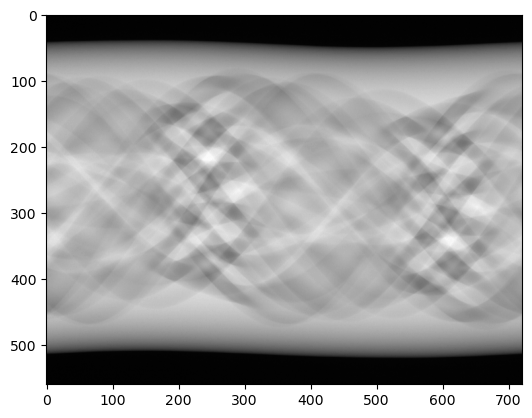

In [8]:
# angles must be last dimension
sinogram = sinogram.transpose(1, 0)
## TODO: flip sinogram to have correct orientation
plt.imshow(sinogram, cmap="gray")

#### Reconstruct

Now perform a reconstruction, with the sinogram. Easy peasy, use any algorithm you like!

Starting gradient descent
Number of iterations: 1000


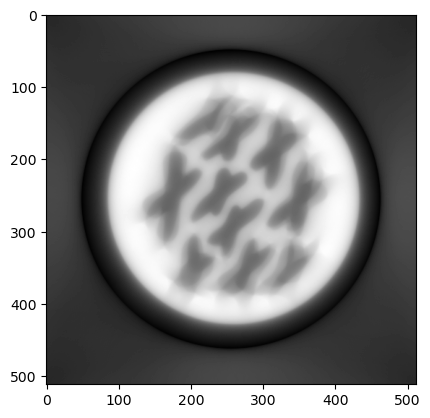

In [14]:
x0 = np.zeros(vol_shape, dtype="float32")
reco = aomip.GD(A, sinogram, x0).l2Norm()
plt.imshow(reco, cmap="gray")

#### Quality of the reconstruction

What do you see? Compare it with the ground truth data. By now, you should know the challenge dataset good enough, to quickly see something is wrong. But what is wrong? Can you guess the mistake?

In any case, if you don't know the dataset, that can be challenging. So how can you compute a measure of a "good" reconstruction, given you don't really know the ground truth.

The trick is to compare the forward projection of your reconstruction, with the sinogram. If they are close then you can be sure that you're reconstruction is good.

However! This is only true for real data, for synthetic data, this is called the inverse crime, which we will dig into some other day.

So do the forward projection of your reconstruction and compare it to the original sinogram!

0.108150214


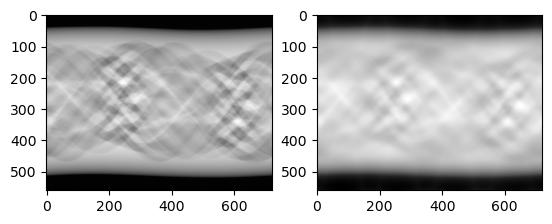

In [15]:
rec_sino = A.apply(reco)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sinogram, cmap="gray")
ax[1].imshow(rec_sino, cmap="gray")
print(np.linalg.norm(sinogram - rec_sino)/np.linalg.norm(sinogram))